# Noisy scans from  102-104
are analyzed


In [1]:
import beamtime_config_2022
from beamtime_config_2022 import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns

import xrf_roif_2022

from xrf_roif_2022 import *

import xrfm_batches
from xrfm_batches import *

import fuzzy_kmeans_engine
from fuzzy_kmeans_engine import _format_soft_km_axes, soft_clustering_weights

%matplotlib inline

# import coarse scans but do not apply gaussian fileter

In [2]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'


# coarse_scan_names = ['bnp_fly0032.mda.h5']


coarse_scan_names = ['bnp_fly0102.mda.h5',
                     'bnp_fly0103.mda.h5',
                     'bnp_fly0104.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type]
# bin_conv_elm_list=['P','P','P']
bin_conv_elm_list=['KPSCa','KPSCa','KPSCa']
value_offset_list = [1e-12,1e-12,1e-12]
apply_gausssian_list=[False, False, False]


In [3]:
coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gausssian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)


XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0102.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(18, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0103.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(16, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0104.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(17, 14)
Bounding box width and height (pixels): 32
Total extracted cells, features: (51, 14)
Total extracted cell, cell size: (51, 32, 32)


# preview coarse channel images for the segmentation elemental map (Phosphorus)

Text(0.5, 1.0, 'bnp_fly0104.mda.h5')

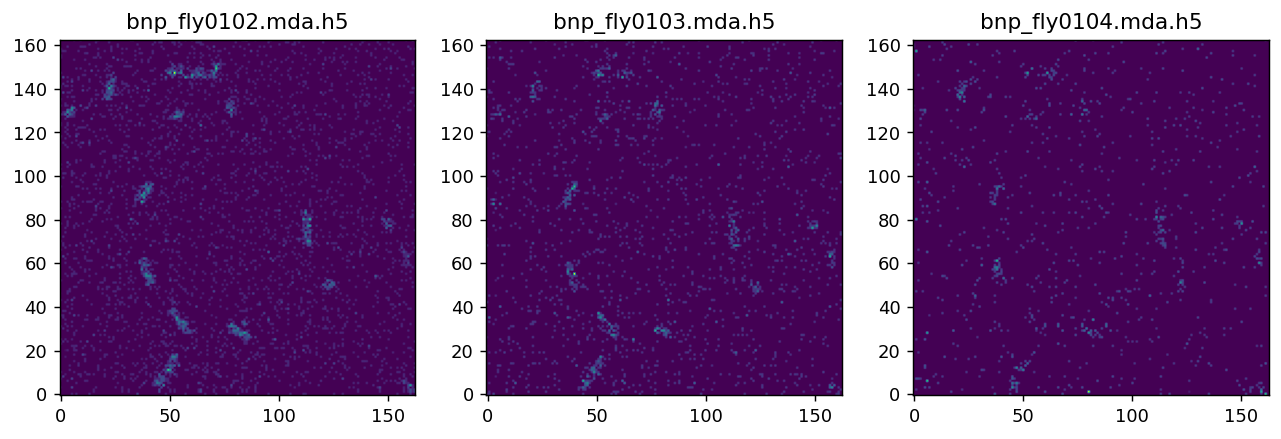

In [4]:
idx = 0
fig, ax = plt.subplots(1,3 ,figsize = (12,4), dpi=130)


ax[0].imshow(coarse_scans.X_d_P[idx])
ax[0].invert_yaxis()   
ax[0].set_title(coarse_scans.coarse_scan_names[idx])
ax[1].imshow(coarse_scans.X_d_P[idx+1])
ax[1].invert_yaxis()   
ax[1].set_title(coarse_scans.coarse_scan_names[idx+1])
ax[2].imshow(coarse_scans.X_d_P[idx+2])
ax[2].invert_yaxis()   
ax[2].set_title(coarse_scans.coarse_scan_names[idx+2])

# plt.colorbar(orientation='horizontal', shrink=0.5)



Text(0.5, 1.0, 'bnp_fly0104.mda.h5\ndwell time = 12.5ms')

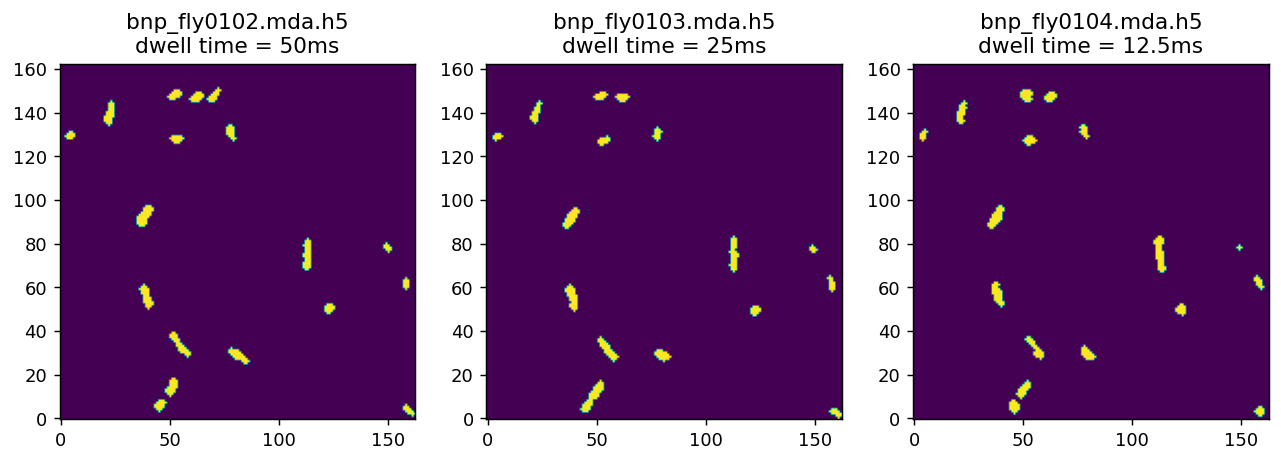

In [5]:
idx = 0
fig, ax = plt.subplots(1,3 ,figsize = (12,4), dpi=130)


ax[0].imshow(coarse_scans.X_binary_ero_dil[idx] )
ax[0].invert_yaxis()   
ax[0].set_title(coarse_scans.coarse_scan_names[idx] + '\ndwell time = 50ms')
ax[1].imshow(coarse_scans.X_binary_ero_dil[idx+1])
ax[1].invert_yaxis()   
ax[1].set_title(coarse_scans.coarse_scan_names[idx+1] + '\ndwell time = 25ms')
ax[2].imshow(coarse_scans.X_binary_ero_dil[idx+2])
ax[2].invert_yaxis()   
ax[2].set_title(coarse_scans.coarse_scan_names[idx+2] + '\ndwell time = 12.5ms')

# plt.colorbar(orientation='horizontal', shrink=0.5)



#  Questions

1. With respect to the best case, how many cells are being missed in the other data with faster dwell times?
a

# instructions
1. Get the mask from the P channel of the best case. 

2. Then do this, find the sigma for which SNR is max for the 2nd and 3rd case.



[1.6426101618166042, 0.9666207565706918, 0.7969715721660678]


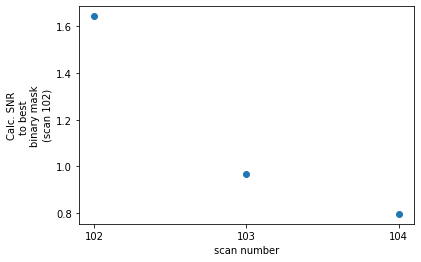

In [6]:
best_case_binary_mask = coarse_scans.X_binary_ero_dil[0]

# P channel images from each of the scans
img_102 = coarse_scans.X_d_P[0] #best case
img_103 = coarse_scans.X_d_P[1]
img_104 = coarse_scans.X_d_P[2]

# calc_SNR(img_101, best_case_binary_mask)

calculated_SNRs = [calc_SNR(img_102, best_case_binary_mask),calc_SNR(img_103, best_case_binary_mask),calc_SNR(img_104, best_case_binary_mask)]
scan_no = ['102','103','104']
plt.scatter(scan_no,calculated_SNRs);
plt.xlabel("scan number")
plt.ylabel("Calc. SNR\nto best \nbinary mask\n(scan 102)")
print(calculated_SNRs)


# for scan 103 optimize sigma

Sigma corresponding to max SNR:  2.6


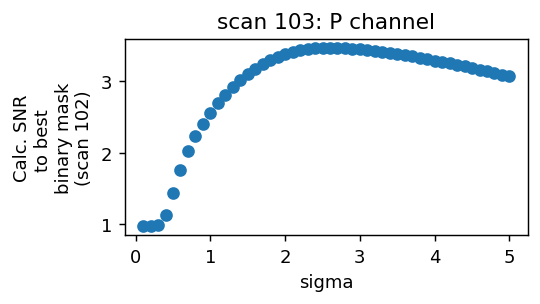

In [7]:
calculated_SNRs = []
sigma_list = np.linspace(0.1,5,50).tolist()
for sigma in sigma_list:
#     print(calc_SNR(gaussian_filter(img_103, sigma), best_case_binary_mask))
    calculated_SNRs.append(calc_SNR(gaussian_filter(img_103, sigma), best_case_binary_mask))

print('Sigma corresponding to max SNR: ', sigma_list[np.argmax(calculated_SNRs)])    
plt.figure(figsize=(4,2), dpi=130)
plt.scatter(sigma_list, calculated_SNRs)
plt.title('scan 103: P channel')
plt.xlabel('sigma')
plt.ylabel("Calc. SNR\nto best \nbinary mask\n(scan 102)");

# for scan 104 optimize sigma

Sigma corresponding to max SNR:  2.7


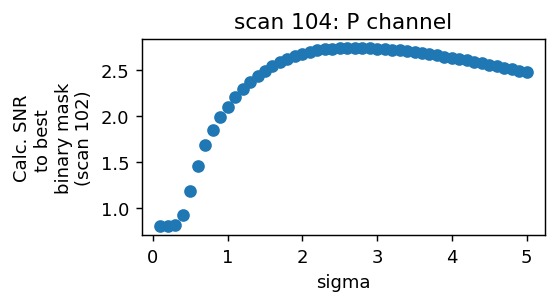

In [8]:
calculated_SNRs = []
sigma_list = np.linspace(0.1,5,50).tolist()
for sigma in sigma_list:
#     print(calc_SNR(gaussian_filter(img_103, sigma), best_case_binary_mask))
    calculated_SNRs.append(calc_SNR(gaussian_filter(img_104, sigma), best_case_binary_mask))

print('Sigma corresponding to max SNR: ', sigma_list[np.argmax(calculated_SNRs)])    
plt.figure(figsize=(4,2), dpi=130)
plt.scatter(sigma_list, calculated_SNRs)
plt.title('scan 104: P channel')
plt.xlabel('sigma')
plt.ylabel("Calc. SNR\nto best \nbinary mask\n(scan 102)");

# now apply gaussian filter with best sigmas for scan 103 and 104 which are the most noisy cases and compare with the best binary mask from the best case without applying the gaussian filter.

In [9]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'


# coarse_scan_names = ['bnp_fly0032.mda.h5']


coarse_scan_names = ['bnp_fly0102.mda.h5',
                     'bnp_fly0103.mda.h5',
                     'bnp_fly0104.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type]
bin_conv_elm_list=['KPSCa','KPSCa','KPSCa']
value_offset_list = [1e-12,1e-12,1e-12]
apply_gausssian_list=[False, True, True]


coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gausssian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)


XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0102.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(18, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0103.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(15, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0104.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(15, 14)
Bounding box width and height (pixels): 32
Total extracted cells, features: (48, 14)
Total extracted cell, cell size: (48, 32, 32)


In [10]:
# View the binary converted images after adding gaussian filter to 103 and 104 coarse scans

Text(0.5, 1.0, 'bnp_fly0104.mda.h5')

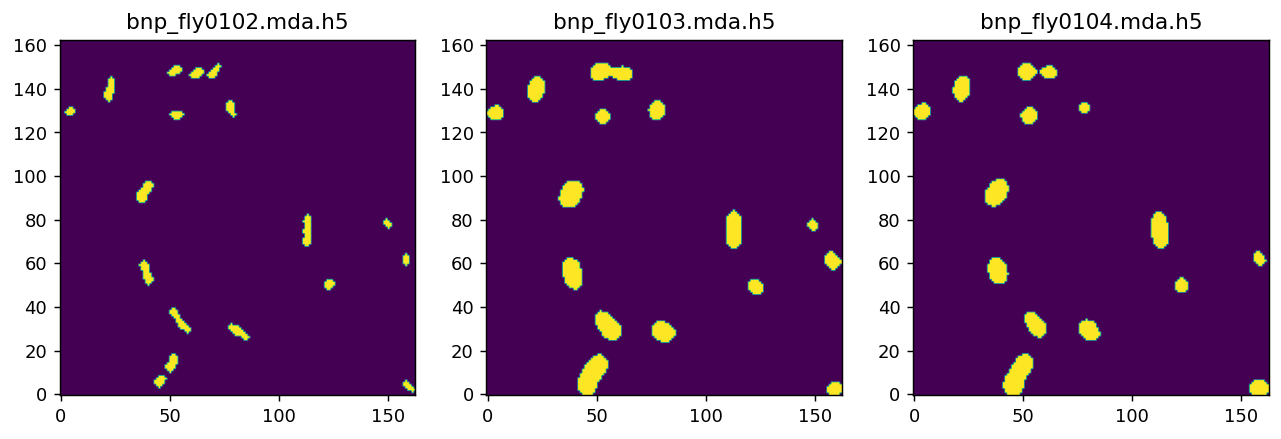

In [11]:
idx = 0
fig, ax = plt.subplots(1,3 ,figsize = (12,4), dpi=130)


ax[0].imshow(coarse_scans.X_binary_ero_dil[idx])
ax[0].invert_yaxis()   
ax[0].set_title(coarse_scans.coarse_scan_names[idx])
ax[1].imshow(coarse_scans.X_binary_ero_dil[idx+1])
ax[1].invert_yaxis()   
ax[1].set_title(coarse_scans.coarse_scan_names[idx+1])
ax[2].imshow(coarse_scans.X_binary_ero_dil[idx+2])
ax[2].invert_yaxis()   
ax[2].set_title(coarse_scans.coarse_scan_names[idx+2])

# plt.colorbar(orientation='horizontal', shrink=0.5)



In [12]:
x_102 = beamtime_XRF_image(xrf_filename=base_file_path + coarse_scan_names[0],
    BASE_PATCH_WIDTH=32,
    norm_ch='US_IC',
    value_offset=1e-12,
    apply_gaussian = False,
    verbosity=False,
    print_pv=False,)

x_102.load_xrf_data(hdf5_string='MAPS')
x_102.load_element_maps(selected_elm_maps = selected_elm_maps )                        

x_102.binary_conversion(e='P')

XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0102.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']


In [13]:
x_103 = beamtime_XRF_image(xrf_filename=base_file_path + coarse_scan_names[1],
    BASE_PATCH_WIDTH=32,
    norm_ch='US_IC',
    value_offset=1e-12,
    apply_gaussian = True,
    verbosity=False,
    print_pv=False,)

x_103.load_xrf_data(hdf5_string='MAPS')
x_103.load_element_maps(selected_elm_maps = selected_elm_maps )                        

x_103.binary_conversion(e='P')

XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0103.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']


In [14]:
x_104 = beamtime_XRF_image(xrf_filename=base_file_path + coarse_scan_names[2],
    BASE_PATCH_WIDTH=32,
    norm_ch='US_IC',
    value_offset=1e-12,
    apply_gaussian = True,
    verbosity=False,
    print_pv=False,)

x_104.load_xrf_data(hdf5_string='MAPS')
x_104.load_element_maps(selected_elm_maps = selected_elm_maps )                        

x_104.binary_conversion(e='P')


XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0104.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']


Text(0.5, 1.0, 'bnp_fly0104.mda.h5')

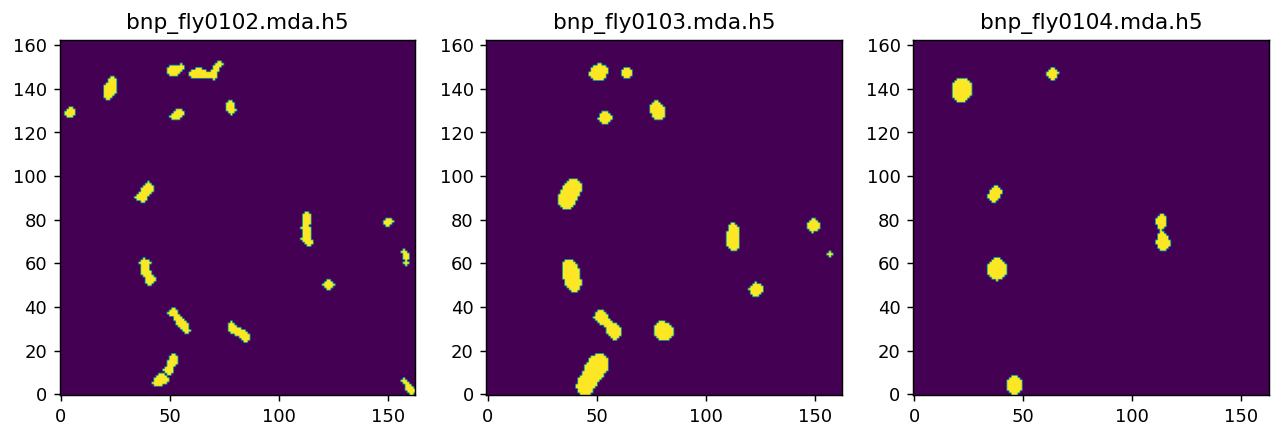

In [15]:
fig, ax = plt.subplots(1,3 ,figsize = (12,4), dpi=130)

ax[0].imshow(x_102.binary_ero_dil)
ax[0].invert_yaxis()   
ax[0].set_title(coarse_scans.coarse_scan_names[0])
ax[1].imshow(x_103.binary_ero_dil)
ax[1].invert_yaxis()   
ax[1].set_title(coarse_scans.coarse_scan_names[1])
ax[2].imshow(x_104.binary_ero_dil)
ax[2].invert_yaxis()   
ax[2].set_title(coarse_scans.coarse_scan_names[2])


Do the analysis with 

Morphology of the cells are being lost with faster dwell time. After a certain threshold nothing is visible. So dwell time can be reduced by a factor of 2 while elemental maps are not affected as much. So the method should


We need to establish, that upto a certain dwell time with gaussian filtering we would get good clustering 



Clusters were caused by increasing K level (when only median filter is applied)
In these experiments, while it is not certain for scans 102-104, iif they are live or dead, but they contained high potassium, our observation was that faster dwell times reduced the number of cells detected, however, those cells that were detected still fall to correct region in the cluster space, which is high degree of potassiun. 


MAKE ONE PCA PLOT,

instead of scan numbers put dwell time based filtering in your plot. 

All the live ones should say live, 

all the dead cells should be dead. 

for the noisy ones just put,

size of the noisy marker should be inversely proportional to dwell time. 

# now import live and dead coarse scans and these noisy scans to make one PCA plot to show the PC-space 

In [16]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'


# coarse_scan_names = ['bnp_fly0032.mda.h5']


coarse_scan_names = ['bnp_fly0032.mda.h5', 
                    'bnp_fly0042.mda.h5',
                    'bnp_fly0043.mda.h5',
                    'bnp_fly0073.mda.h5',
                    'bnp_fly0082.mda.h5',
                    'bnp_fly0102.mda.h5',
                    'bnp_fly0103.mda.h5',
                    'bnp_fly0104.mda.h5']


# 'bnp_fly0050.mda.h5',
#                     'bnp_fly0051.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS','MAPS','MAPS','MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC','US_IC','US_IC','US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type,noise_type,noise_type,noise_type,noise_type]
# bin_conv_elm_list=['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
bin_conv_elm_list=['KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa']
apply_gausssian_list=[False, False, False, False,False,False,False,False]
value_offset_list = [1e-12,1e-12,1e-12,1e-12,1e-12,1e-12,1e-12,1e-12]

BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'



coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gausssian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)



XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0032.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(41, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0042.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(36, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0043.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(17, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0073.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(19, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0082.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(11, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0102.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(18, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0103.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(16, 14)
XRF /data02/AZC/March_2022_XRF_Dat

/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:106: RuntimeWarning: divide by zero encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)
/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:106: RuntimeWarning: invalid value encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)


In [17]:

print(len(hdf5_string_list))
print(len(norm_ch_list))
print(len(selected_elm_maps_list))
print(len(noise_type_list))
print(len(bin_conv_elm_list))
print(len(apply_gausssian_list))
print(len(value_offset_list))


8
8
8
8
8
8
8


(321, 321)
(321, 321)
(149, 321)
(321, 321)
(118, 321)
(163, 163)
(163, 163)
(163, 163)


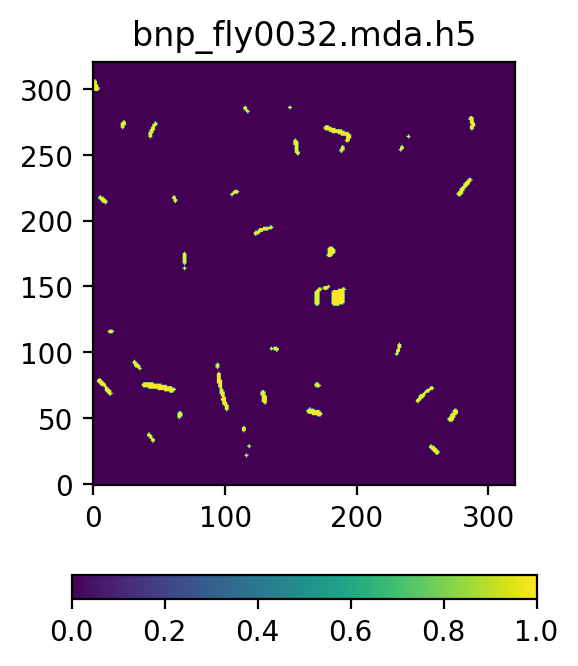

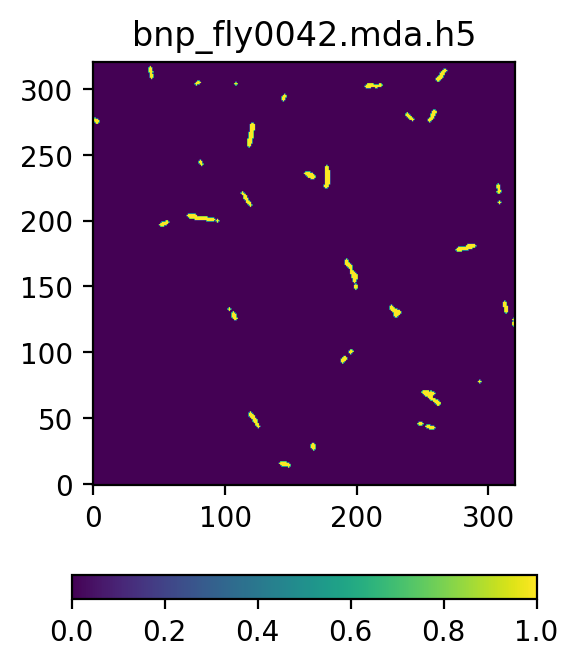

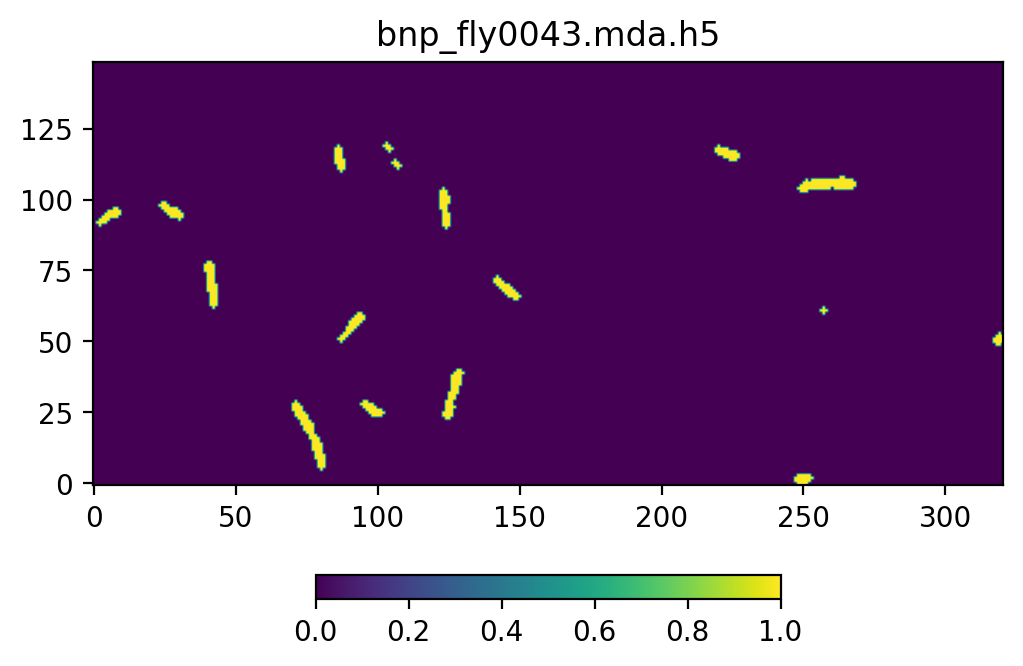

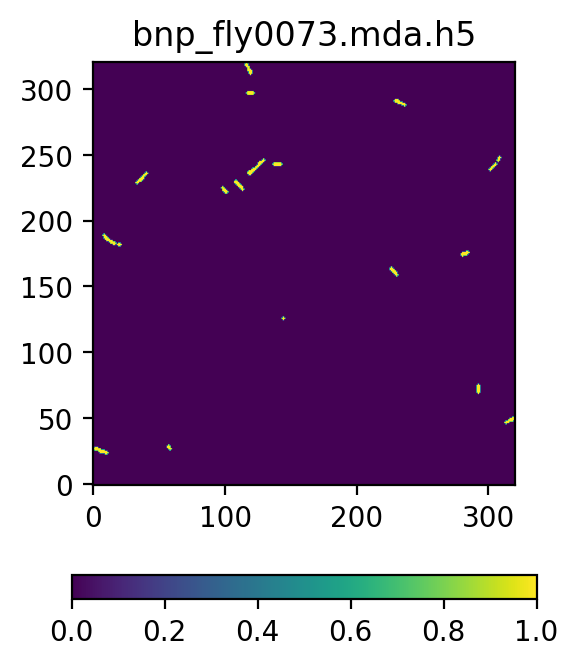

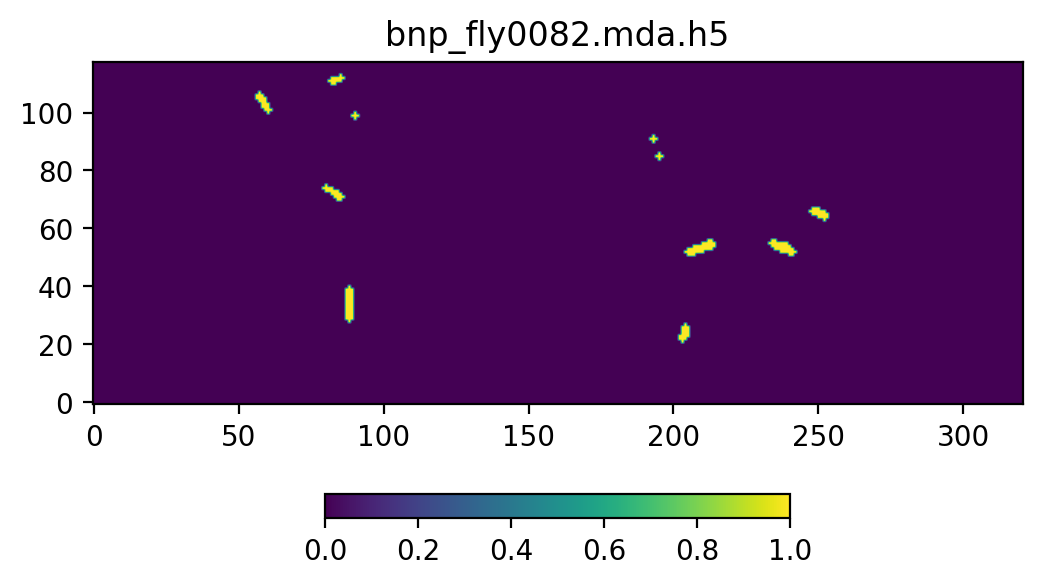

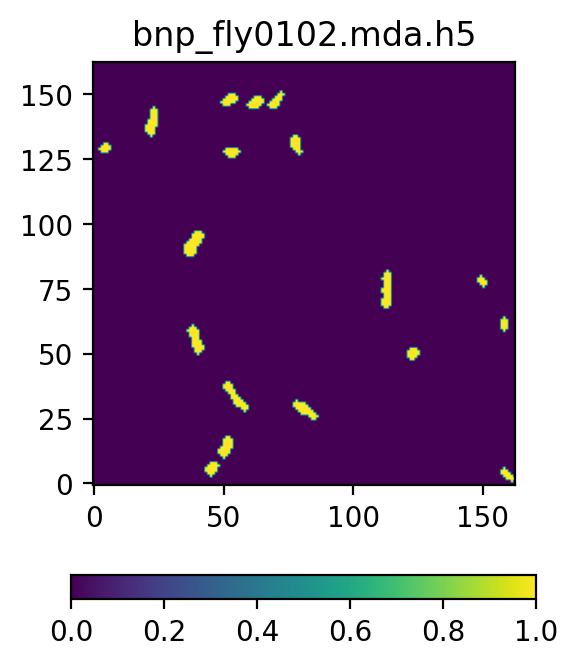

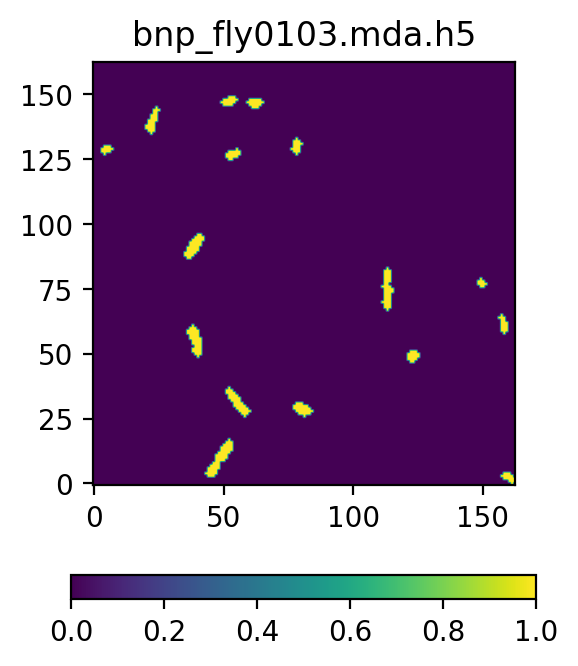

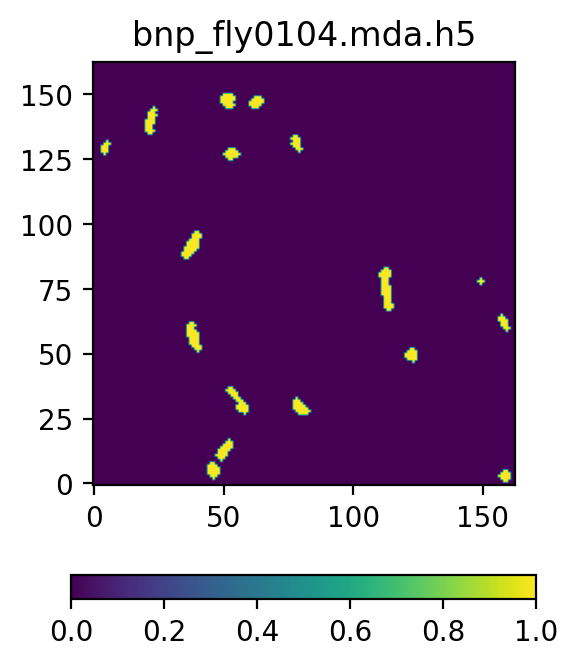

In [18]:
coarse_scans.plot_coarse_binary_images()

# construct dataframe with all the extracted information

In [19]:
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])


principalDf['area'] = coarse_scans.X[:,0]
principalDf['eccentricity'] = coarse_scans.X[:,1]
principalDf['equivalent_diameter'] = coarse_scans.X[:,2]
principalDf['major_axis_length'] = coarse_scans.X[:,3]
principalDf['minor_axis_length'] = coarse_scans.X[:,4]
principalDf['perimeter'] = coarse_scans.X[:,5]
principalDf['K'] = coarse_scans.X[:,6]
principalDf['P'] = coarse_scans.X[:,7]
principalDf['Ca'] = coarse_scans.X[:,8]
principalDf['Zn'] = coarse_scans.X[:,9]
principalDf['Fe'] = coarse_scans.X[:,10]
principalDf['Cu'] = coarse_scans.X[:,11]
principalDf['BFY'] = coarse_scans.X[:,12]
principalDf['Pixel_count'] = coarse_scans.X[:,13].astype(int)   #Pixel_count column must exist

#add res and origins to dataframe here
#convert from list
principalDf['x_res'] = coarse_scans.X_x_res
principalDf['y_res'] = coarse_scans.X_y_res
principalDf['avg_res'] = coarse_scans.X_avg_res
principalDf['x_origin'] = coarse_scans.X_x_origin
principalDf['y_origin'] = coarse_scans.X_y_origin
principalDf['x_motor'] = coarse_scans.X_x_motor
principalDf['y_motor'] = coarse_scans.X_y_motor
principalDf['xrf_file']=coarse_scans.X_xrf_track_files




#assign scan names in dataframe
number_of_cells = principalDf['xrf_file'].to_numpy().shape[0]
coarse_scan_name=[]
for idx in range(number_of_cells):

    coarse_scan_name.append(os.path.split(principalDf['xrf_file'].to_numpy()[idx])[1])
principalDf['scan_name'] =  np.array(coarse_scan_name)  


display(principalDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name
0,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000042,0.000038,0.000047,...,0.007212,0.25,0.256287,0.253143,110.674377,-661.065186,139.674377,-655.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
1,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
2,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000036,0.000046,0.000051,...,0.007115,0.25,0.256287,0.253143,110.674377,-661.065186,140.174377,-653.815186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
3,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
4,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,14,0.8750,0.850688,1.055502,1.465135,0.770179,2.767767,0.000104,0.000051,0.000135,...,0.000799,0.25,0.272903,0.261452,800.212036,-155.992310,801.212036,-123.742310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5
171,20,1.2500,0.859510,1.261566,1.810667,0.925465,3.828427,0.000111,0.000067,0.000038,...,0.000813,0.25,0.272903,0.261452,800.212036,-155.992310,819.462036,-123.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5
172,34,2.1250,0.939338,1.644881,2.891355,0.991711,5.681981,0.000133,0.000077,0.000038,...,0.000947,0.25,0.272903,0.261452,800.212036,-155.992310,805.462036,-121.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5
173,29,1.8125,0.432967,1.519127,1.606889,1.448465,4.474874,0.000136,0.000089,0.000035,...,0.000954,0.25,0.272903,0.261452,800.212036,-155.992310,812.962036,-119.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5


# remove extracted cells that contain less than certain amount of pixels

In [20]:
secondaryDf=remove_artifacts(principalDf, remove_count = 8)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

# secondaryDf.head()

/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:810: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['original index'] = secondaryDf.index.to_numpy()


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,0.000071,0.000048,0.000072,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,0.000051,0.000035,0.000046,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,0.000053,0.000040,0.000037,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,0.000055,0.000042,0.000059,0.007298,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,0.000070,0.000044,0.000052,0.007146,0.25,0.256287,0.253143,110.674377,-661.065186,126.924377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6
5,49,3.0625,0.925859,1.974664,3.245418,1.226342,7.035534,0.000044,0.000089,0.000127,0.000077,0.000041,0.000051,0.007242,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,7
6,95,5.9375,0.993093,2.749520,8.450952,0.991554,15.906854,0.000055,0.000079,0.000064,0.000049,0.000051,0.000058,0.007374,0.25,0.256287,0.253143,110.674377,-661.065186,134.924377,-643.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,8
7,38,2.3750,0.927087,1.738949,2.844144,1.066118,5.974874,0.000055,0.000073,0.000113,0.000045,0.000046,0.000046,0.007229,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,9
8,47,2.9375,0.984730,1.933944,4.921048,0.856704,7.303301,0.000050,0.000099,0.000051,0.000058,0.000039,0.000058,0.007299,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-644.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,10
9,50,3.1250,0.977717,1.994711,4.549151,0.955001,8.010408,0.000050,0.000064,0.000114,0.000078,0.000044,0.000051,0.007258,0.25,0.256287,0.253143,110.674377,-661.065186,112.674377,-642.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,11


In [21]:
# secondaryDf[secondaryDf['scan_name'] == 'bnp_fly0104.mda.h5'].count()

# view the location of a cell on main XRF image
must be in matplotlib inline mode

In [22]:
%matplotlib inline
coarse_scans.ROI_viewer(selected_elm_channel = 'P', linethresh_val=0.00001)


interactive(children=(IntSlider(value=87, description='idx', max=174), Output()), _dom_classes=('widget-intera…

# view all extracted cells

In [23]:

linethresh_val=0.00001
# resolution=DEFAULT_RESOLUTION_CELL

%matplotlib inline

def viewer(idx):    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(coarse_scans.X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*coarse_scans.X_x_res[idx], "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(coarse_scans.X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(coarse_scans.X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(coarse_scans.X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(coarse_scans.X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(coarse_scans.X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(coarse_scans.X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(coarse_scans.X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(coarse_scans.X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(coarse_scans.X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(coarse_scans.X_Cu[idx]))
    print('Avg. Zn:',np.average(coarse_scans.X_Zn[idx]))
    print('Avg. Ca:',np.average(coarse_scans.X_Ca[idx]))
    print('Avg. K:',np.average(coarse_scans.X_K[idx]))
    print('Avg. P:',np.average(coarse_scans.X_P[idx]))
    print('Avg. S:',np.average(coarse_scans.X_S[idx]))
    print('Avg. Fe:',np.average(coarse_scans.X_Fe[idx]))
    print('Avg. Ni:',np.average(coarse_scans.X_Ni[idx]))
    print('Avg. TFY:',np.average(coarse_scans.X_TFY[idx]))
    
    print('Max. Cu:',np.max(coarse_scans.X_Cu[idx]))
    print('Max. Zn:',np.max(coarse_scans.X_Zn[idx]))
    print('Max. Ca:',np.max(coarse_scans.X_Ca[idx]))
    print('Max. K:',np.max(coarse_scans.X_K[idx]))
    print('Max. P:',np.max(coarse_scans.X_P[idx]))
    print('Max. S:',np.max(coarse_scans.X_S[idx]))
    print('Max. Fe:',np.max(coarse_scans.X_Fe[idx]))
    print('Max. Ni:',np.max(coarse_scans.X_Ni[idx]))
    print('Max. TFY:',np.max(coarse_scans.X_TFY[idx]))
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(coarse_scans.X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot



interactive(children=(IntSlider(value=87, description='idx', max=174), Output()), _dom_classes=('widget-intera…

# Construct the features for PCA

In [24]:
# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe'],
#     secondaryDf['Cu'],secondaryDf['BFY']
#                ]).T

# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
#                ]).T


mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
               ]).T

print('Cells, features', mod_X.shape)

Cells, features (156, 7)


# perform PCA

PC = f('area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe')
         

Cells, PCs (156, 2)
singular_values_: [20.27365555 14.17534267]
explained_variance: [2.65174909 1.29638929]
components: [[ 0.2112239   0.34539418 -0.38822042  0.44833624  0.52280108  0.45658445
  -0.05075946]
 [ 0.64040329  0.39040773  0.47810755 -0.16334869  0.03959646 -0.02283494
   0.42438956]]


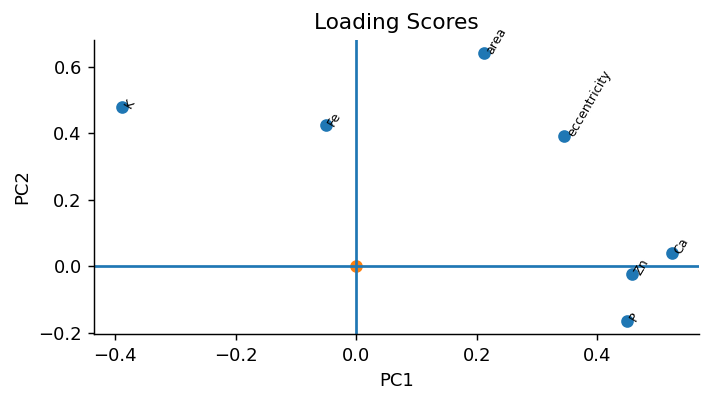

<Figure size 432x288 with 0 Axes>

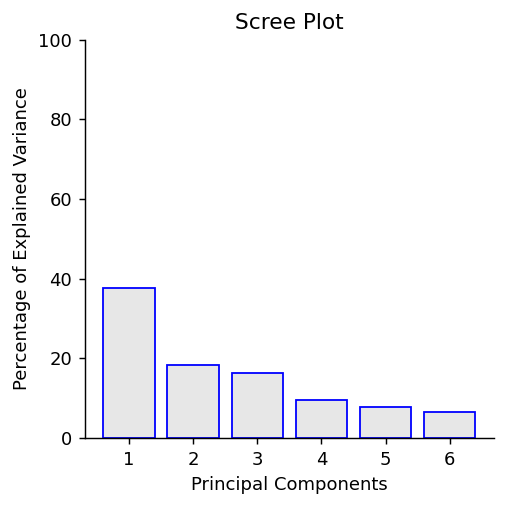

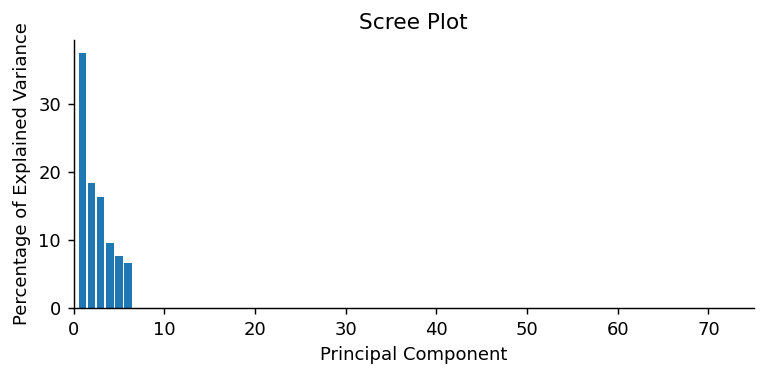

/tmp/ipykernel_28903/247549750.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC1']=principalComponents[:,0]
/tmp/ipykernel_28903/247549750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC2']=principalComponents[:,1]


IndexError: index 2 is out of bounds for axis 1 with size 2

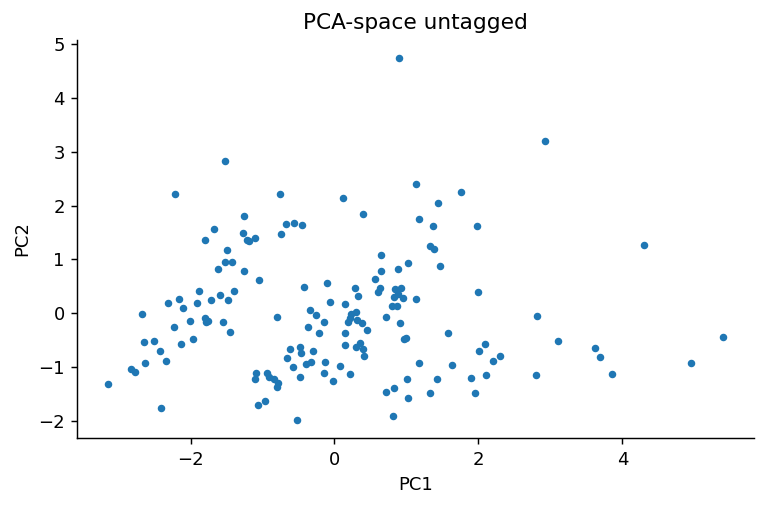

In [26]:
%matplotlib inline

# feature_names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
#         'K','P','Ca','Zn',
#          'Fe']

feature_names = ['area','eccentricity','K','P','Ca','Zn','Fe']


principalComponents, loading_scores = XRF_PCA(mod_X, feature_names, high_comp=6, n_components=2, 
                                              annot_txt_size=7, dpi =130, marker_size=3,save_plots=True)

#assign PC values to dataframe
secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]
secondaryDf['PC3']=principalComponents[:,2]



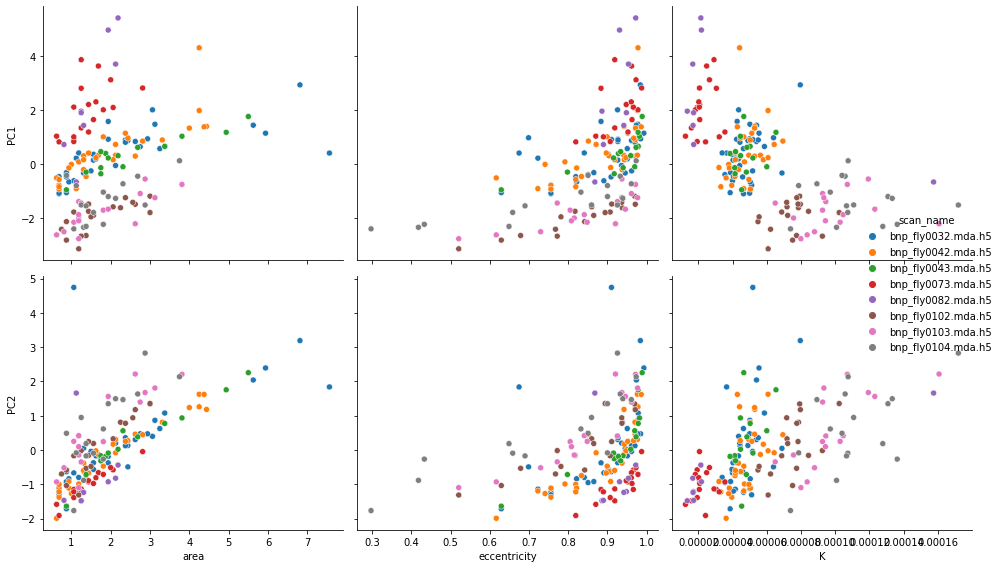

In [27]:
secondaryDf
# feature_list = ["area", "eccentricity","K","P"]
feature_list = ["area", "eccentricity", "K"]
# feature_list = ["K","P"]
# PC_names=["PC1", "PC2","PC3"]
PC_names=["PC1", "PC2"]

    
view_PC_feature_relation(secondaryDf,PC_names, feature_list, hue = 'scan_name',save_plots=True )

In [28]:
loading_scores.shape[1]

7

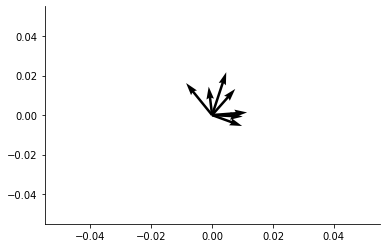

In [29]:
fig, ax = plt.subplots()

scale_size=5
for idx in range(loading_scores.shape[1]):
#     print(idx)
    ax.quiver(0,0, loading_scores[:, idx][0],loading_scores[:, idx][1],scale=scale_size)

for i, txt in enumerate(feature_names):
    ax.annotate(txt, (loading_scores[:, i][0], loading_scores[:, i][1]), size=15)
    

# ax.plot(X,Y1,'o')
# ax.plot(X,Y2,'x')
plt.show()

0.21122389670188163
0.6404032907928378
0.34539418360412266
0.3904077261133159
-0.38822042086470054
0.4781075471636349
0.4483362378256693
-0.16334868942757422
0.5228010781743281
0.03959646200542363
0.45658444614071786
-0.02283493609516748
-0.05075945500701294
0.4243895585784169
[ 0.2112239   0.34539418 -0.38822042  0.44833624  0.52280108  0.45658445
 -0.05075946]
[ 0.64040329  0.39040773  0.47810755 -0.16334869  0.03959646 -0.02283494
  0.42438956]


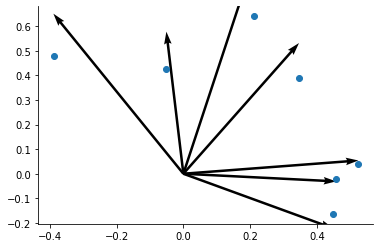

In [30]:
for idx in range(loading_scores.shape[1]):
#     print(idx)
    print(loading_scores[:, idx][0])
    print(loading_scores[:, idx][1])
    plt.quiver(0,0, loading_scores[:, idx][0],loading_scores[:, idx][1],scale=1)
    

plt.scatter(loading_scores[0],loading_scores[1])    
print(loading_scores[0])
print(loading_scores[1])
# for i, txt in enumerate(feature_names):
#     plt.annotate(txt, (loading_scores[0][i], loading_scores[0][i]), size=15)
plt.show()

In [31]:
# import plotly.express as px
fig = px.scatter_3d(secondaryDf, x='PC1', y='PC2', z='PC3', symbol='scan_name', size_max=5,
              color='eccentricity',size='area')

fig.update_traces(marker_size = 4)
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    )
fig.show()
fig.write_image('../figures/PCA_eccentricity_3D.jpg')


ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['Pixel_count', 'area', 'eccentricity', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'K', 'P', 'Ca', 'Zn', 'Fe', 'Cu', 'BFY', 'x_res', 'y_res', 'avg_res', 'x_origin', 'y_origin', 'x_motor', 'y_motor', 'xrf_file', 'scan_name', 'original index', 'PC1', 'PC2'] but received: PC3

In [ ]:
plt.scatter(loading_scores[0],loading_scores[1])

# tag based off of experiments, so we can see the effect of sample prep.

In [ ]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='scan_name', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Scan number based annotation')
plt.tight_layout()
plt.savefig('../figures/pc_space_scan_tagged.jpg')

In [32]:
print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &    area &  eccentricity &         K &         P &        Ca &        Zn &        Fe \\
\midrule
0   &  1.9375 &      0.926864 &  0.000042 &  0.000085 &  0.000074 &  0.000071 &  0.000048 \\
1   &  1.3125 &      0.945323 &  0.000069 &  0.000055 &  0.000065 &  0.000051 &  0.000035 \\
2   &  0.6875 &      0.755929 &  0.000046 &  0.000057 &  0.000034 &  0.000053 &  0.000040 \\
3   &  2.6250 &      0.926738 &  0.000054 &  0.000088 &  0.000078 &  0.000055 &  0.000042 \\
4   &  1.1250 &      0.722659 &  0.000042 &  0.000064 &  0.000100 &  0.000070 &  0.000044 \\
5   &  3.0625 &      0.925859 &  0.000044 &  0.000089 &  0.000127 &  0.000077 &  0.000041 \\
6   &  5.9375 &      0.993093 &  0.000055 &  0.000079 &  0.000064 &  0.000049 &  0.000051 \\
7   &  2.3750 &      0.927087 &  0.000055 &  0.000073 &  0.000113 &  0.000045 &  0.000046 \\
8   &  2.9375 &      0.984730 &  0.000050 &  0.000099 &  0.000051 &  0.000058 &  0.000039 \\
9   &  3.1250 &      0.9777

/tmp/ipykernel_28903/2506169708.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))


# perform k-means for 3 clusters

/tmp/ipykernel_28903/2514215907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['Class'] = kmeans.labels_


inertia:  264.851476099549


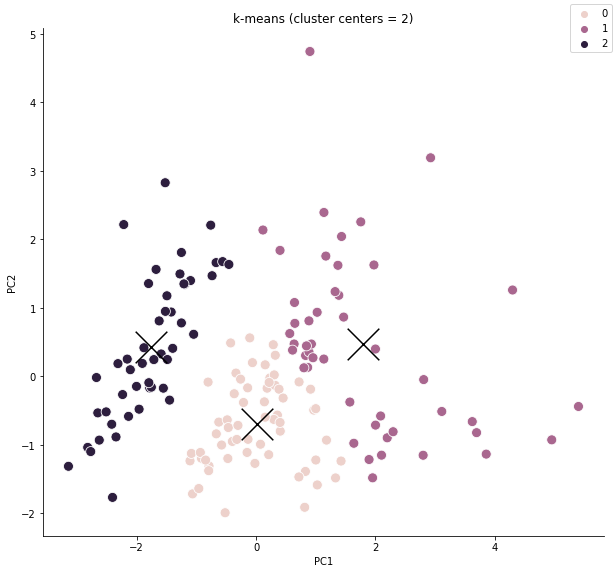

In [33]:


kmeans = KMeans(init="k-means++",n_clusters = 3, n_init=200, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered.jpg')



# mark cluster boundaries

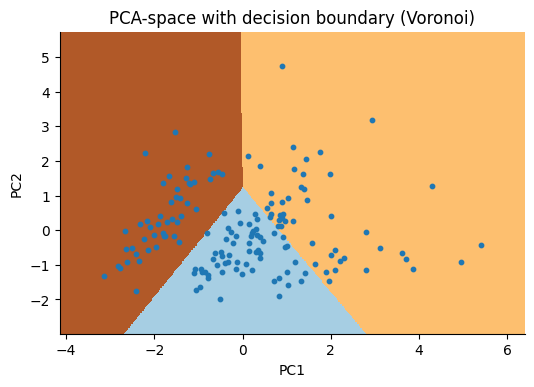

In [34]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(dpi=100)
plt.scatter(principalComponents[:,0],principalComponents[:,1], s=10)
plt.title('PCA-space with decision boundary (Voronoi)')
plt.xlabel('PC1')
plt.ylabel('PC2')



plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)


# use mean-shift

In [35]:
from sklearn.cluster import MeanShift, estimate_bandwidth


bandwidth = estimate_bandwidth(principalComponents, quantile=0.5)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(coarse_scans.X)
_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(ms.labels_)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 20


# apply scan based filter to annotate live cells, dead cells and noisy cells with dwell time



[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0

/tmp/ipykernel_28903/3995568795.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels
/tmp/ipykernel_28903/3995568795.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['dwell_times'] = dwell_times
/tmp/ipykernel_28903/3995568795.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

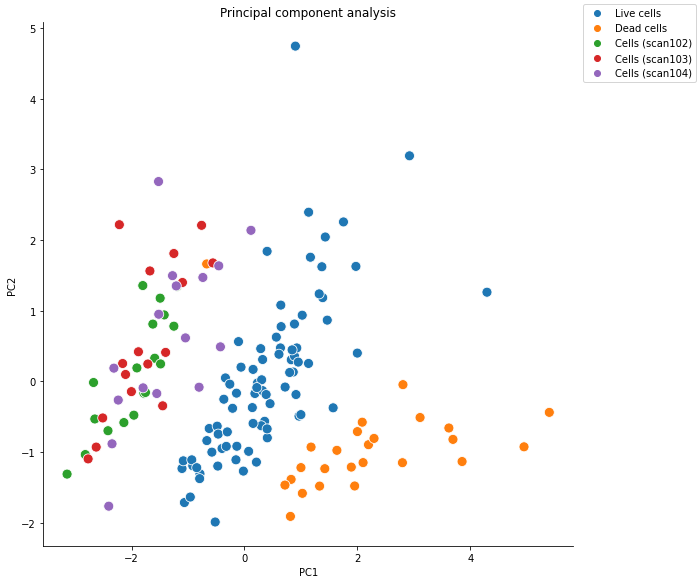

In [36]:
# condition check

labels = [0] * mod_X.shape[0]
dwell_times = [float(100)] * mod_X.shape[0]
print(dwell_times)
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
# print(labels)



True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0102.mda.h5') 
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=50.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0103.mda.h5') 
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )
for idx in True_list:
    labels[idx]=3 
    dwell_times[idx]=25.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0104.mda.h5') 
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )
for idx in True_list:
    labels[idx]=4 
    dwell_times[idx]=12.5
    
    
print(labels)

y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = 'Dead cells'
    if text_labels[idx] ==1:
        text_labels[idx] = 'Live cells'
    if text_labels[idx] ==2:
        text_labels[idx] = 'Cells (scan102)'
    if text_labels[idx] ==3:
        text_labels[idx] = 'Cells (scan103)'
    if text_labels[idx] ==4:
        text_labels[idx] = 'Cells (scan104)'
        
secondaryDf['text_labels'] = text_labels
secondaryDf['dwell_times'] = dwell_times
secondaryDf['inv_dwell_times'] = np.reciprocal(np.array(dwell_times))

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')

plt.savefig('../figures/Noise_Analysis1.jpg')

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0

/tmp/ipykernel_28903/3522325203.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28903/3522325203.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28903/3522325203.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



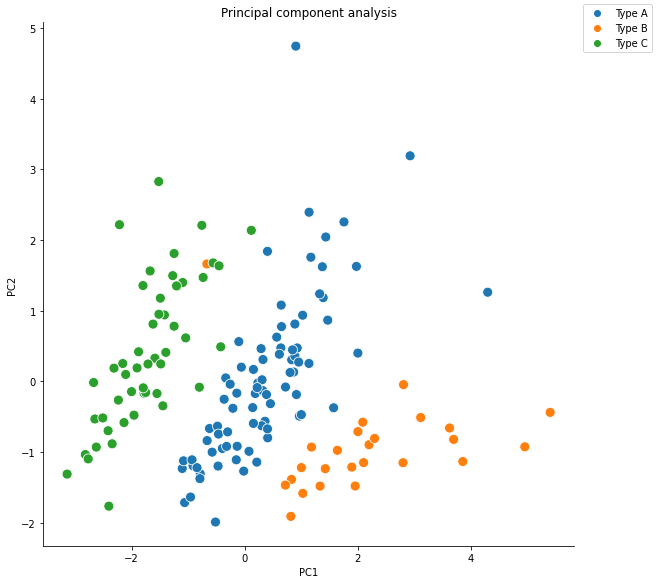

In [54]:
# condition check

labels = [0] * mod_X.shape[0]
dwell_times = [float(100)] * mod_X.shape[0]
print(dwell_times)
text_labels=labels

True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
# print(labels)



True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0102.mda.h5') 
   ].index.tolist()    
    
print('Length true list 102 : ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=50.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0103.mda.h5') 
   ].index.tolist()    
    
print('Length true list 103: ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=25.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0104.mda.h5') 
   ].index.tolist()    
    
print('Length true list 104: ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=12.5
    
print('Length true list: ', len(True_list) )
print(labels)

y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = 'Type B'
    if text_labels[idx] ==1:
        text_labels[idx] = 'Type A'
    if text_labels[idx] ==2:
        text_labels[idx] = 'Type C'
   
        
secondaryDf['text_labels'] = text_labels
secondaryDf['dwell_times'] = dwell_times
secondaryDf['inv_dwell_times'] = np.reciprocal(np.array(dwell_times))

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')

plt.savefig('../figures/Noise_Analysis1.jpg')

In [55]:
import plotly.express as px



# fig = px.scatter(secondaryDf, x='PC1', y='PC2', size_max=15,
#               color='text_labels',size='inv_dwell_times', template='simple_white')

fig = px.scatter(secondaryDf, x='PC1', y='PC2', size_max=15,
              color='text_labels',size='area', template='simple_white',width=600, height=600)


# fig.update_traces(marker_size = 4)
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    )


fig.update_layout(
    legend=dict(
        x=0.8,
        y=1.0,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)



fig.show()
fig.write_image('../figures/PC_space_tagged.jpg')


In [56]:
scores_df = pd.DataFrame(
             columns = feature_names)
scores_df.loc[0]=loading_scores[0]
scores_df.loc[1]=loading_scores[1]

scores_df

,area,eccentricity,K,P,Ca,Zn,Fe
0,0.211224,0.345394,-0.388220,0.448336,0.522801,0.456584,-0.050759
1,0.640403,0.390408,0.478108,-0.163349,0.039596,-0.022835,0.424390


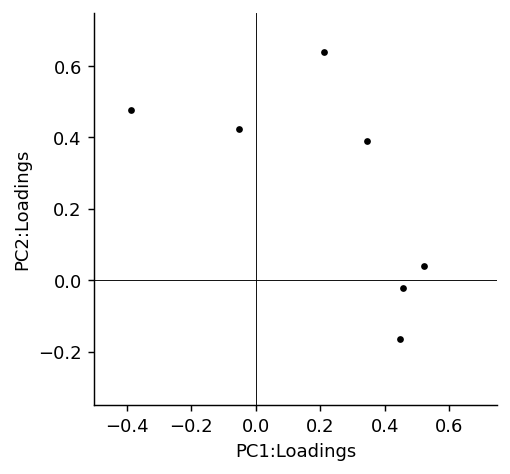

In [57]:
annot_txt_size=8

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.figure(figsize=(4,4),dpi=130)
plt.scatter(loading_scores[0],loading_scores[1],color='black',s=7.5) #, tick_label=PClabels
# plt.title('Loading Scores')
plt.xlabel('PC1:Loadings')
plt.ylabel('PC2:Loadings')
plt.axhline(color='black', linewidth = 0.5)
plt.axvline(color='black', linewidth = 0.5)
plt.xlim([-0.50,0.75])
plt.ylim([-0.35,0.75])

# figure_scale_factor=2
# plt.xlim([fig.data[0]['x'].min()/figure_scale_factor,fig.data[0]['x'].max()/figure_scale_factor])
# plt.ylim([fig.data[0]['y'].min()/figure_scale_factor,fig.data[0]['y'].max()/figure_scale_factor])


# plt.arrow(x=0, y=0, dx=loading_scores[0][0], dy=loading_scores[1][0], width=.005) 
 
arrow_scale_factor=0.85
# for i, txt in enumerate(feature_names):
# #     plt.arrow(x=0, y=0, dx=arrow_scale_factor*loading_scores[0][i], dy=arrow_scale_factor*loading_scores[1][i], 
# #               width=.005,color ='black') 
#     plt.annotate(str('  ')+txt, (loading_scores[0][i], loading_scores[1][i]), rotation=0, size=annot_txt_size)
    
# plt.axis()
plt.savefig('../figures/PC_space_loading_scores.jpg')

In [58]:
loading_scores[1]

array([ 0.64040329,  0.39040773,  0.47810755, -0.16334869,  0.03959646,
       -0.02283494,  0.42438956])

In [59]:
secondaryDf[secondaryDf['text_labels']== 'Type A']['PC1'].to_numpy()

array([ 0.91307846, -0.33718917, -1.10695885,  0.82963809,  0.21192395,
        2.000079  ,  1.13702704,  0.8863357 ,  0.92716118,  1.46714122,
        2.92431743, -1.06445688,  0.13935703, -0.78860706, -0.25948867,
       -0.62469644, -1.0837385 ,  0.56470899,  0.40125527, -0.39737765,
        0.185071  ,  0.96663888,  0.63740443,  0.35755807, -0.32237986,
        0.90244971,  0.64394627,  0.8646061 , -0.66651018, -0.47312137,
        1.43219543,  0.80123444, -0.0609967 ,  0.40518086, -0.48306146,
        1.57133696,  1.00002628, -0.91591666,  0.2979499 ,  0.28805722,
       -0.79396527,  1.38641537,  0.07405472, -0.51865379, -0.13527189,
       -0.46522147,  0.8441062 ,  0.3185878 , -0.93387829,  1.97484056,
        0.88587788,  0.40187687,  1.37154559,  0.32182686,  0.1526731 ,
        1.32423733,  0.72036308, -0.5776377 ,  4.29730732, -0.01944914,
        0.15258728, -0.21075786, -0.15075711,  0.95352768, -0.84568845,
        1.13502008,  0.23058068, -0.30353844,  1.75431415,  1.02

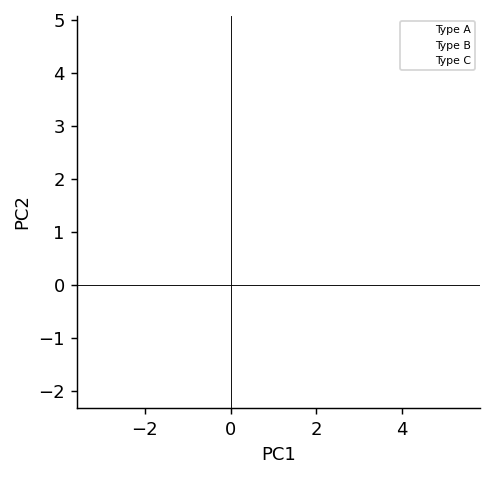

In [61]:
plt.figure(figsize=(4,4),dpi=130)
plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type A']['PC1'].to_numpy(),
            secondaryDf[secondaryDf['text_labels']== 'Type A']['PC2'].to_numpy(),
            color='blue',s=secondaryDf[secondaryDf['text_labels']== 'Type A']['area'].to_list(), label='Type A')

plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type B']['PC1'].to_numpy(),
            secondaryDf[secondaryDf['text_labels']== 'Type B']['PC2'].to_numpy(),
            color='orange',s=secondaryDf[secondaryDf['text_labels']== 'Type B']['area'].to_list(), label='Type B') 

plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type C']['PC1'].to_numpy(),
            secondaryDf[secondaryDf['text_labels']== 'Type C']['PC2'].to_numpy(),
            color='green',s=secondaryDf[secondaryDf['text_labels']== 'Type C']['area'].to_list(), label='Type C')

plt.legend(loc=1, prop={'size': 6})

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(color='black', linewidth = 0.5)
plt.axvline(color='black', linewidth = 0.5)

# plt.scatter(loading_scores[0],loading_scores[1],color='black',s=7.5) # loading scores marker

# arrow_scale_factor=1.5
# for i, txt in enumerate(feature_names):
#     plt.arrow(x=0, y=0, dx=arrow_scale_factor*loading_scores[0][i], dy=arrow_scale_factor*loading_scores[1][i], 
#               width=.005,color ='black') 
#     plt.annotate(str('  ')+txt, (loading_scores[0][i], loading_scores[1][i]), rotation=0, size=0.5*annot_txt_size)


# count cells from each XRF

In [44]:
secondaryDf[secondaryDf['scan_name']=='bnp_fly0082.mda.h5'].count()

Pixel_count            8
area                   8
eccentricity           8
equivalent_diameter    8
major_axis_length      8
minor_axis_length      8
perimeter              8
K                      8
P                      8
Ca                     8
Zn                     8
Fe                     8
Cu                     8
BFY                    8
x_res                  8
y_res                  8
avg_res                8
x_origin               8
y_origin               8
x_motor                8
y_motor                8
xrf_file               8
scan_name              8
original index         8
PC1                    8
PC2                    8
Class                  8
text_labels            8
dwell_times            8
inv_dwell_times        8
dtype: int64

# fuzzy k-means (currently works for 2 PCs)

In [45]:
df=secondaryDf

In [46]:
df

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,y_motor,xrf_file,scan_name,original index,PC1,PC2,Class,text_labels,dwell_times,inv_dwell_times
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1,0.913078,-0.186104,0,Type A,100.0,0.01
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3,-0.337189,0.048974,0,Type A,100.0,0.01
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,-650.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4,-1.106959,-1.232842,0,Type A,100.0,0.01
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,...,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5,0.829638,0.305931,1,Type A,100.0,0.01
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,...,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6,0.211924,-1.142530,0,Type A,100.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,14,0.8750,0.850688,1.055502,1.465135,0.770179,2.767767,0.000104,0.000051,0.000135,...,-123.742310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5,170,-0.426159,0.489071,0,Type C,12.5,0.08
152,20,1.2500,0.859510,1.261566,1.810667,0.925465,3.828427,0.000111,0.000067,0.000038,...,-123.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5,171,-1.519290,0.950166,2,Type C,12.5,0.08
153,34,2.1250,0.939338,1.644881,2.891355,0.991711,5.681981,0.000133,0.000077,0.000038,...,-121.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5,172,-1.275092,1.496250,2,Type C,12.5,0.08
154,29,1.8125,0.432967,1.519127,1.606889,1.448465,4.474874,0.000136,0.000089,0.000035,...,-119.242310,/data02/AZC/March_2022_XRF_Data/bnp_fly0104.md...,bnp_fly0104.mda.h5,173,-2.236425,-0.264384,2,Type C,12.5,0.08


In [47]:
#for 2 PCs
for i in range(3):
    df['p' + str(i)] = 0
    
# df[['p0', 'p1']] = soft_clustering_weights(X, kmeans.cluster_centers_)
df[['p0', 'p1']] = soft_clustering_weights(principalComponents, kmeans.cluster_centers_)
df['confidence'] = np.max(df[['p0', 'p1']].values, axis = 1)

/tmp/ipykernel_28903/994511390.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28903/994511390.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28903/994511390.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: Columns must be same length as key

In [ ]:
#for 2 PCs, 3 clusters
for i in range(4):
    df['p' + str(i)] = 0
    
# df[['p0', 'p1']] = soft_clustering_weights(X, kmeans.cluster_centers_)
df[['p0', 'p1','p2']] = soft_clustering_weights(principalComponents, kmeans.cluster_centers_)
df['confidence'] = np.max(df[['p0', 'p1','p2']].values, axis = 1)

In [ ]:
df['confidence']

In [48]:
np.unique(df['Class'].to_numpy())

array([0, 1, 2], dtype=int32)

In [49]:
# labels = [0] * mod_X.shape[0]
# text_labels=labels
# True_list = secondaryDf.loc[
#     (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
#     (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
#     (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
#    ].index.tolist()       
    
# print('Length true list: ', len(True_list) )

# for idx in True_list:
#     labels[idx]=1 
# print(labels)
# y_dh=np.array(labels).astype(int)

df['y']=y_dh
df['labels']=y_dh

/tmp/ipykernel_28903/365583922.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28903/365583922.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
df['labels']

0      1
1      1
2      1
3      1
4      1
      ..
151    2
152    2
153    2
154    2
155    2
Name: labels, Length: 156, dtype: int64

In [51]:
# Make sure colours are the same for the actual class and the kmeans class in the plots.
# Count the most frequent species that appears in each class
df_color_converter = df.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']
    
    

In [52]:
len(y_dh)

156

In [53]:
y_dh

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


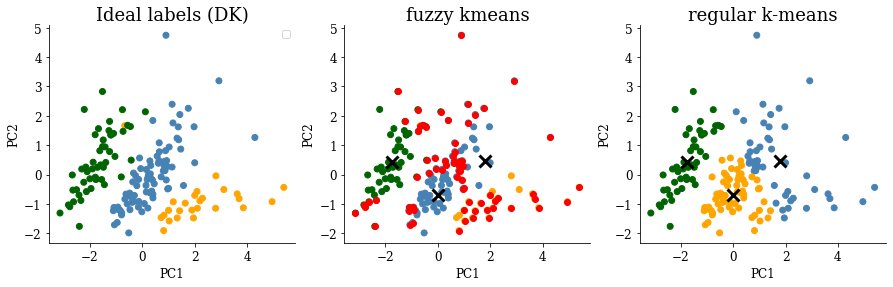

In [279]:
colors = ['orange', 'steelblue','darkgreen']

fig, axs = plt.subplots(1, 3, figsize = (15,4))

ax = _format_soft_km_axes(axs[0])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Ideal labels (DK)', pad = 5, fontsize = 18)
ax.legend()
plt.savefig('../figures/FCKM_ideal_labels.jpg')

# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

# ax.plot(
#     kmeans.cluster_centers_[:,-2],
#     kmeans.cluster_centers_[:,-1],
#     'xk',
#     markersize = 15,
#     markeredgewidth = 3
# )

ax = _format_soft_km_axes(axs[1])

confidence_threshold=0.90 #0.9 default

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.scatter(
    df.loc[df['confidence'] < confidence_threshold, 'PC1'],
    df.loc[df['confidence'] < confidence_threshold, 'PC2'],
#     color = df.loc[df['confidence'] > confidence_threshold, 'Class'].apply(lambda x: colors[color_converter_dict[x]])
    color = ['red']
)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('fuzzy kmeans', pad = 5, fontsize = 18)




ax = _format_soft_km_axes(axs[2])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in kmeans.labels_]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('regular k-means', pad = 5, fontsize = 18)


# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

# plt.savefig('../figures/FCKM.jpg')


In [35]:
#calculated clustering performance metrics

from sklearn import metrics

rand_index=metrics.rand_score(y_dh, kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(y_dh, kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



unadjusted rand index [0,1]: 0.6702290076335878
adjusted rand index [-1,1]: 0.32086665500983164


In [45]:
secondaryDf['x_res']

0      0.25
1      0.25
2      0.25
3      0.25
4      0.25
       ... 
102    0.25
103    0.25
104    0.25
105    0.25
106    0.25
Name: x_res, Length: 107, dtype: float32

# apply a simple condition to filter the data

Length true list:  48
dict_keys(['False', 'True'])


/tmp/ipykernel_27875/2200894824.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



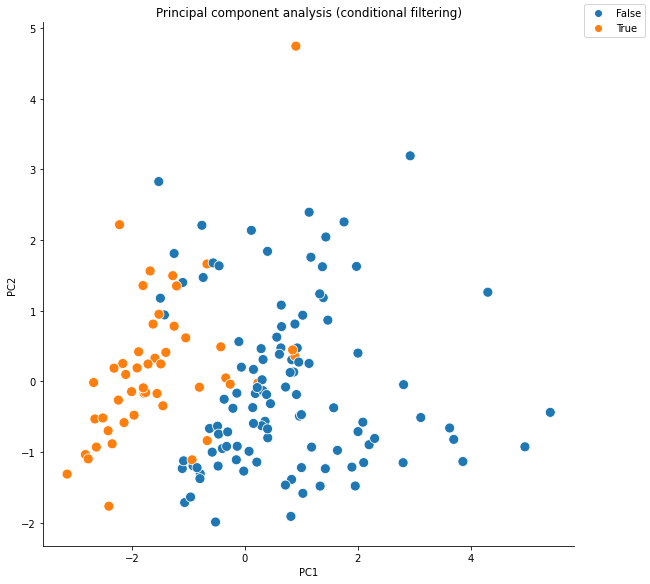

In [75]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 

y_dh=labels    #domain h labels
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = False
    if labels[idx] ==1:
        labels[idx] = True
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



In [47]:
# # look for outliers if exist
# secondaryDf[secondaryDf['PC2']>8]

In [48]:
# # check if the filtering true false labels are correct

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

# secondaryDf['original index']

# view distribution of features for the two kmeans classes

Text(0.5, 1.0, 'k-means (class = 1)')

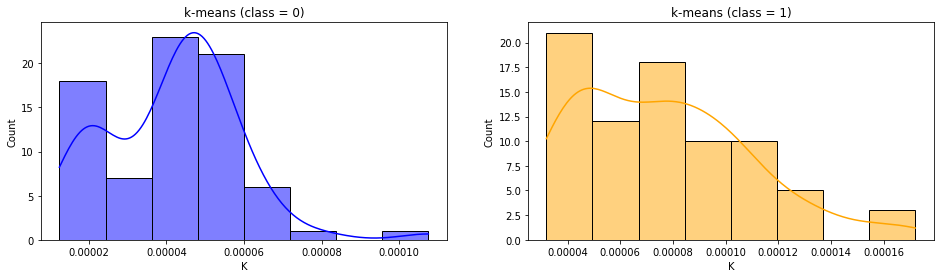

In [76]:
select_feature_channel = 'K'

secondaryDf[secondaryDf['Class']==0][select_feature_channel]
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(ax=ax[0],data=secondaryDf[secondaryDf['Class']==0], x=select_feature_channel, kde=True,color='blue')
ax[0].set_title('k-means (class = 0)')

sns.histplot(ax=ax[1],data=secondaryDf[secondaryDf['Class']==1], x=select_feature_channel, kde=True,color='orange')
ax[1].set_title('k-means (class = 1)')

# view the last xrf files extracted cells on the PC plot marked with orange

Length true list:  8
dict_keys(['previous XRF measurement', 'current measurement'])


/home/otheruser/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


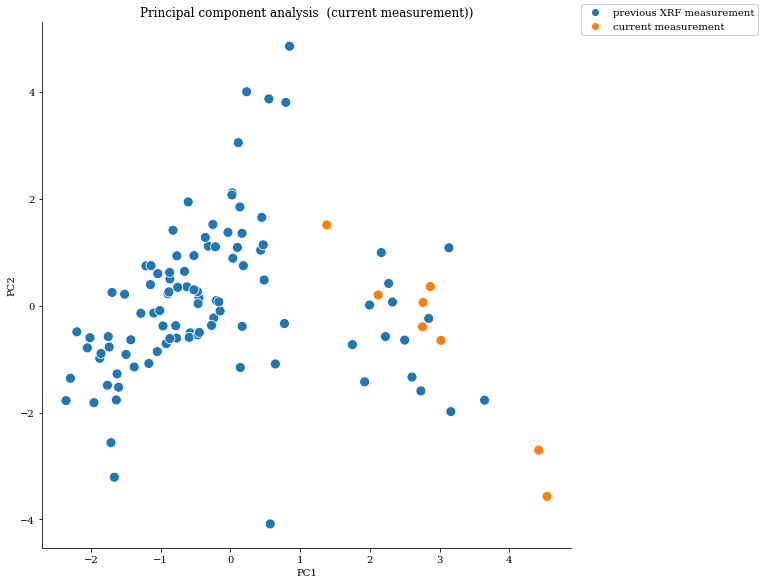

In [60]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[(secondaryDf['xrf_file']==current_xrf_filename)].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'previous XRF measurement'
    if labels[idx] ==1:
        labels[idx] = 'current measurement'
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis  (current measurement))')



<IPython.core.display.Javascript object>


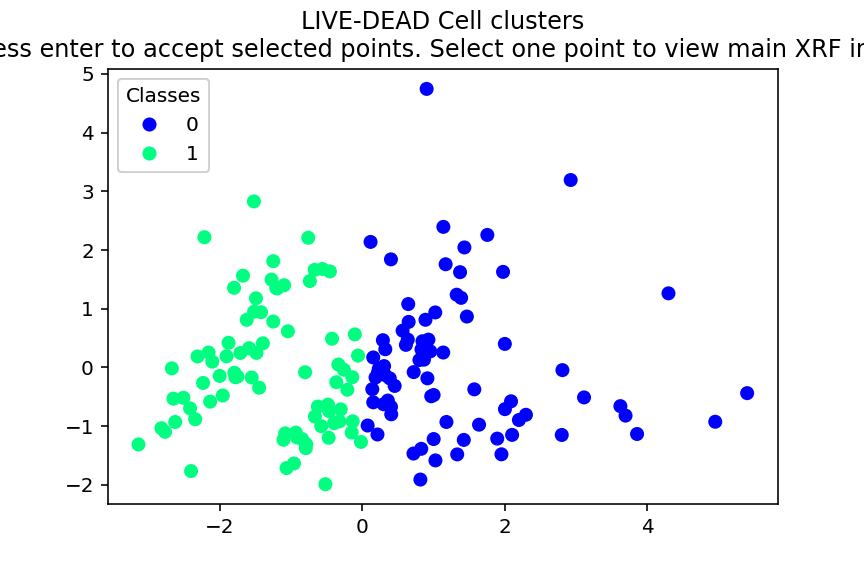

In [77]:
%matplotlib notebook

subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')
pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), c=secondaryDf.Class,
                 cmap='winter')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*pts.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend)

selector = SelectFromCollection(ax, pts)

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("LIVE-DEAD Cell clusters\n Press enter to accept selected points. Select one point to view main XRF image")

plt.show()



In [79]:
#shows selected indices in secondaryDf

print('number of selected cells:', len(selector.ind))

print('modified_indices:', selector.ind)

#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()
print('original indices:', target_scan_cell_indices)
print('K-means classes \n')
secondaryDf['Class'][selector.ind]

print('cell centers (pixel value in XRF image):' , X_centers[target_scan_cell_indices])
print('\n')
print('cell centers in x (pixel value in XRF image):' , X_centers[target_scan_cell_indices][0])
print('\n')
print('cell x_origins (motor coordinates):' , X_x_origin[target_scan_cell_indices])
print('\n')
print('cell y_origins (motor coordinates):' , X_y_origin[target_scan_cell_indices])

print('\n')
print('send to motor')
print('cell x_center (motor coordinates):' , X_x_motor[target_scan_cell_indices])
print('\n')
print('cell y_center (motor coordinates):' , X_y_motor[target_scan_cell_indices])
print('\n')

print('BBox motor width (x): ', BASE_PATCH_WIDTH*X_x_res[target_scan_cell_indices])
print('BBox motor width (y): ', BASE_PATCH_WIDTH*X_y_res[target_scan_cell_indices])


print('Main XRF image file (selected):' , X_xrf_track_files[target_scan_cell_indices])

motor_coordinates = np.vstack((X_x_motor[target_scan_cell_indices],X_y_motor[target_scan_cell_indices])).T
print(motor_coordinates)


number of selected cells: 4
modified_indices: [ 98 129 143 146]
original indices: [113 147 161 164]
K-means classes 



NameError: name 'X_centers' is not defined